# Second Level GLMs - Active vs. Sham

In [72]:
import os, glob
import numpy as np
import pandas as pd

from src.my_settings import settings

from nilearn import plotting as nlp
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel

from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

In [73]:
# Settings
sett = settings()

contrast_name = 'MotorImageryOneTwoMinusRest'

In [74]:
# List all zmap nii.gz files
zmap_nf_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-nf_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_nf_files.sort()

zmap_sham_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-sham_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_sham_files.sort()

n_subjects = len(zmap_nf_files)
print(f"Found {n_subjects} subjects")

Found 22 subjects


In [75]:
# join the two lists
second_level_input = zmap_nf_files + zmap_sham_files

In [76]:
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f"S{i:02d}" for i in range(1, n_subjects + 1)]

In [77]:
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["activeVSsham"] + subjects,
)

<Axes: label='conditions', ylabel='scan number'>

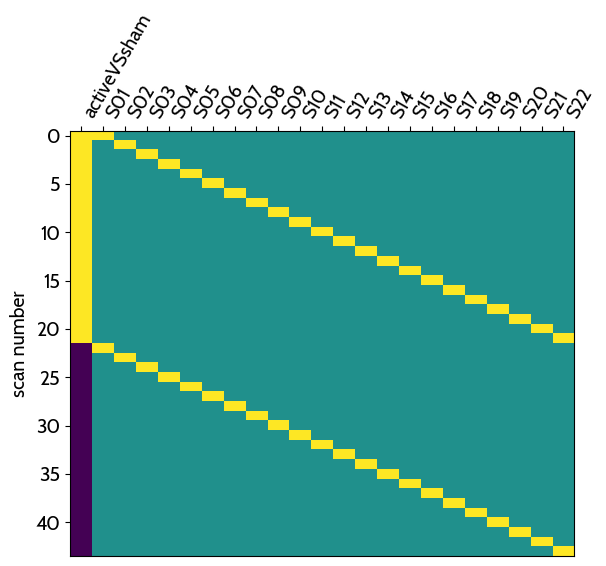

In [78]:
#| label: fig-glm-design-activeVSsham
# plot design matrix
nlp.plot_design_matrix(paired_design_matrix, rescale=False)

In [79]:
second_level_model_paired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(
    second_level_input, design_matrix=paired_design_matrix
)

In [80]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "activeVSsham", output_type="all"
)

In [81]:
stat_maps_paired

{'z_score': <nibabel.nifti1.Nifti1Image at 0x177da1400>,
 'stat': <nibabel.nifti1.Nifti1Image at 0x157d80950>,
 'p_value': <nibabel.nifti1.Nifti1Image at 0x157d809e0>,
 'effect_size': <nibabel.nifti1.Nifti1Image at 0x157d807a0>,
 'effect_variance': <nibabel.nifti1.Nifti1Image at 0x157d80830>}

threshold: 2.575829303548901


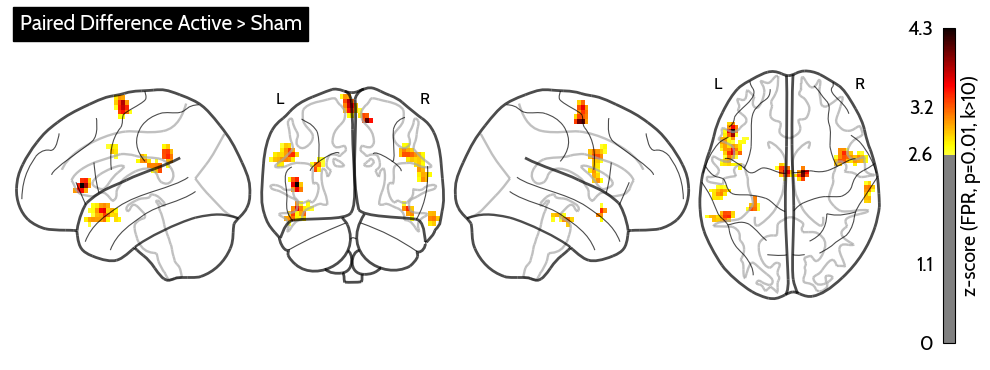

In [82]:
# threshold image
ct = 10
alpha = 0.01
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired["z_score"], cluster_threshold=ct, alpha=alpha, height_control=hc)

print(f"threshold: {thres}")

display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham'
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.01, k>10)')

In [83]:
#| label: tab-glm-clusters-activeVSsham
table_g,cluster_map_g = get_clusters_table(stat_maps_paired["z_score"], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-45.0,27.0,5.79,4.282350,861,Frontal_Inf_Tri_L
1,2,12.0,-6.0,57.66,4.009411,2226,Supp_Motor_Area_R
2,2a,-3.0,-6.0,73.62,3.735294,,Supp_Motor_Area_L
3,3,-45.0,9.0,-14.16,3.568106,2334,Temporal_Pole_Sup_L
4,3a,-51.0,18.0,-22.14,3.025395,,Temporal_Pole_Sup_L
5,3b,-39.0,0.0,-22.14,2.792174,,Undefined
6,4,45.0,9.0,-14.16,3.369839,395,Undefined
7,5,-48.0,-42.0,29.73,3.364761,1544,SupraMarginal_L
8,5a,-60.0,-42.0,25.74,2.913200,,SupraMarginal_L
9,6,-30.0,-36.0,17.76,3.247320,538,Undefined


In [84]:
table_g.to_clipboard()

Active vs. Sham | Imagery | fpr(0.01) | k>10


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



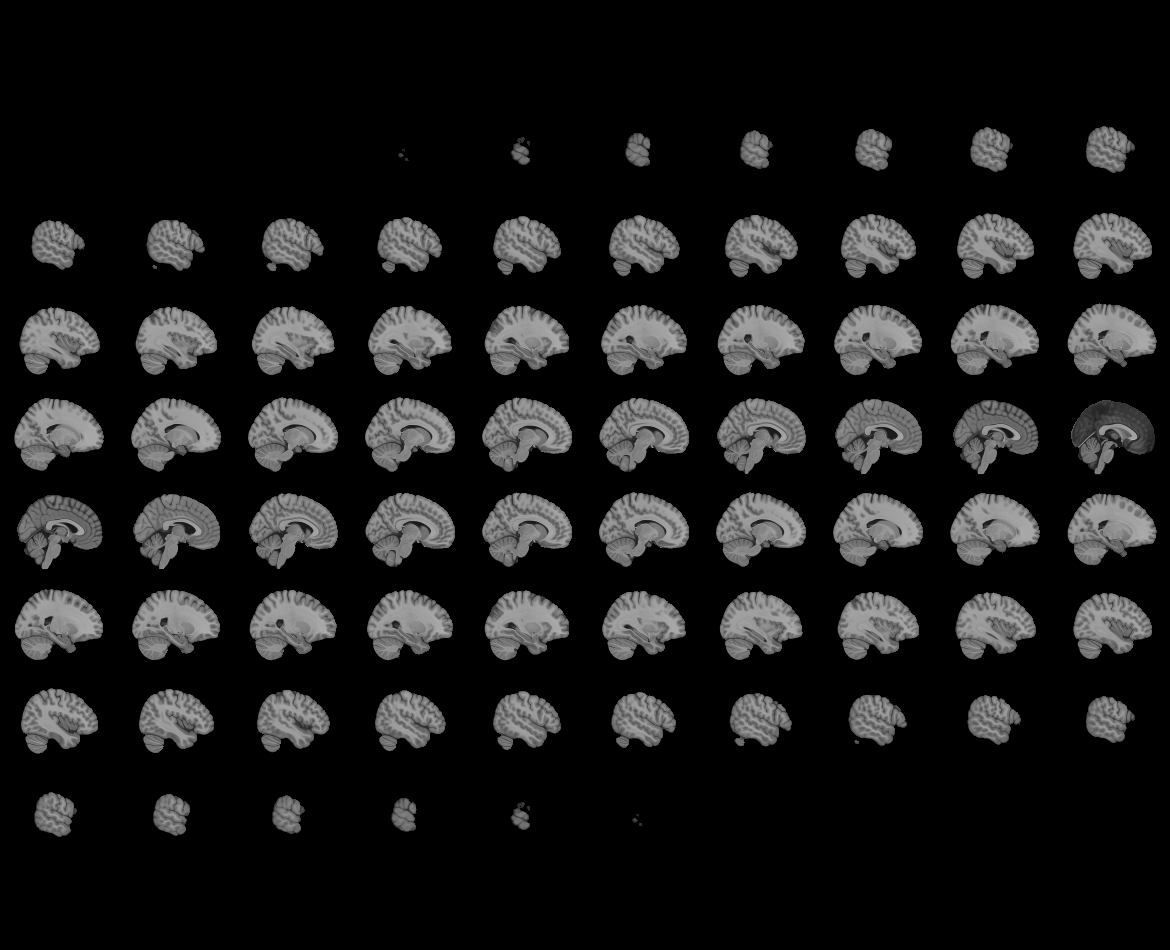
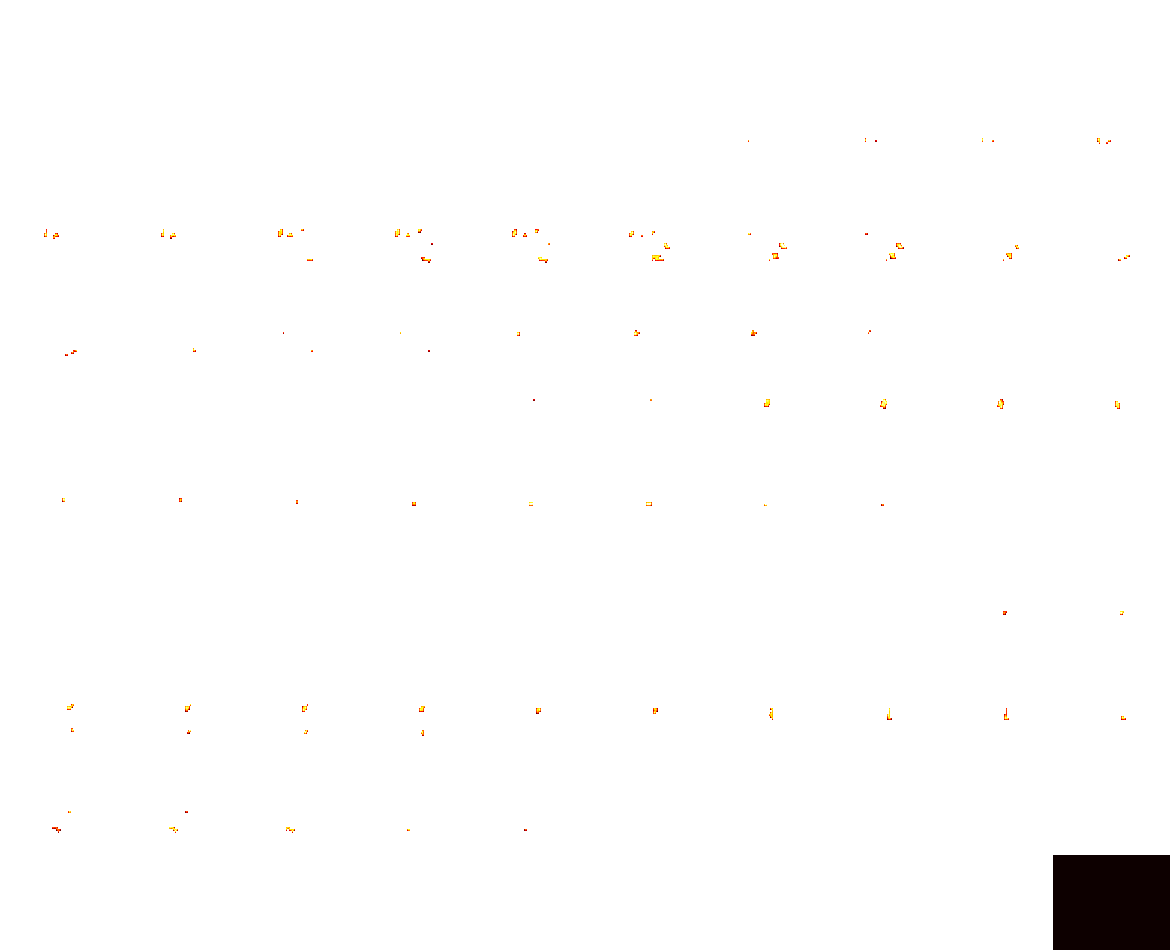

In [85]:
#| label: fig-glm-map-activeVSsham
print(f"Active vs. Sham | Imagery | {hc}({alpha}) | k>{ct}")
nlp.view_img(corrected_map, threshold=thres, colorbar=True)

# Reward ROI from Neurosynth

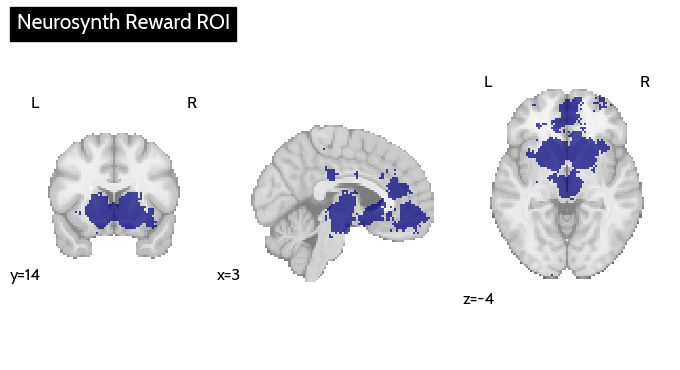

In [86]:
#| label: fig-neurosynth-reward-roi
# load and binarize the roi
from nilearn.image import math_img

roi_path = os.path.join(sett["git_path"], "data", "reward_association-test_z_FDR_0.01.nii.gz")
roi_bin = math_img("img > 0", img=roi_path)

nlp.plot_roi(roi_bin, draw_cross=False, title="Neurosynth Reward ROI")

In [87]:
second_level_model_paired_masked = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked = second_level_model_paired_masked.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


In [88]:
# threshold image
ct = 10
alpha = 0.05
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc)

Active vs. Sham | Imagery | fpr(0.05) | k>10 | Reward ROI


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



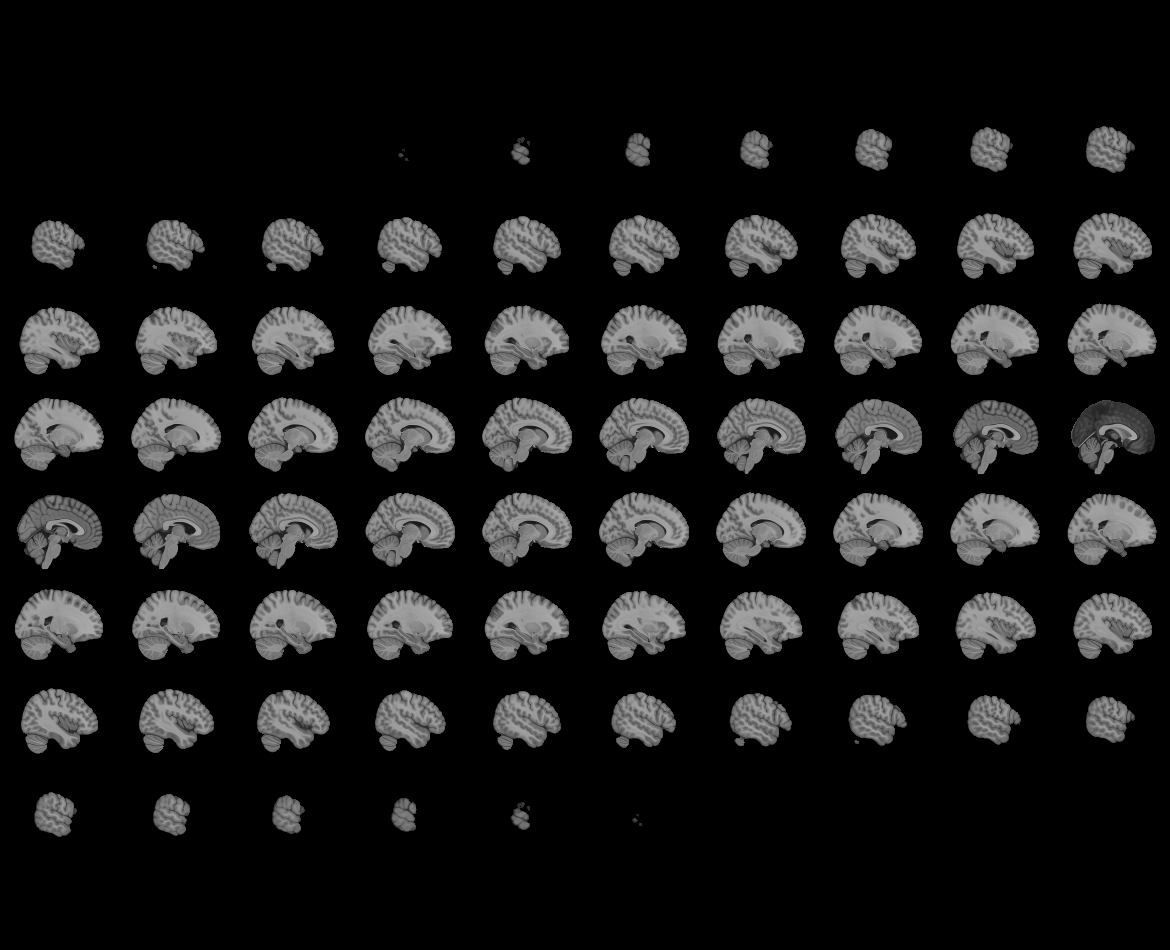
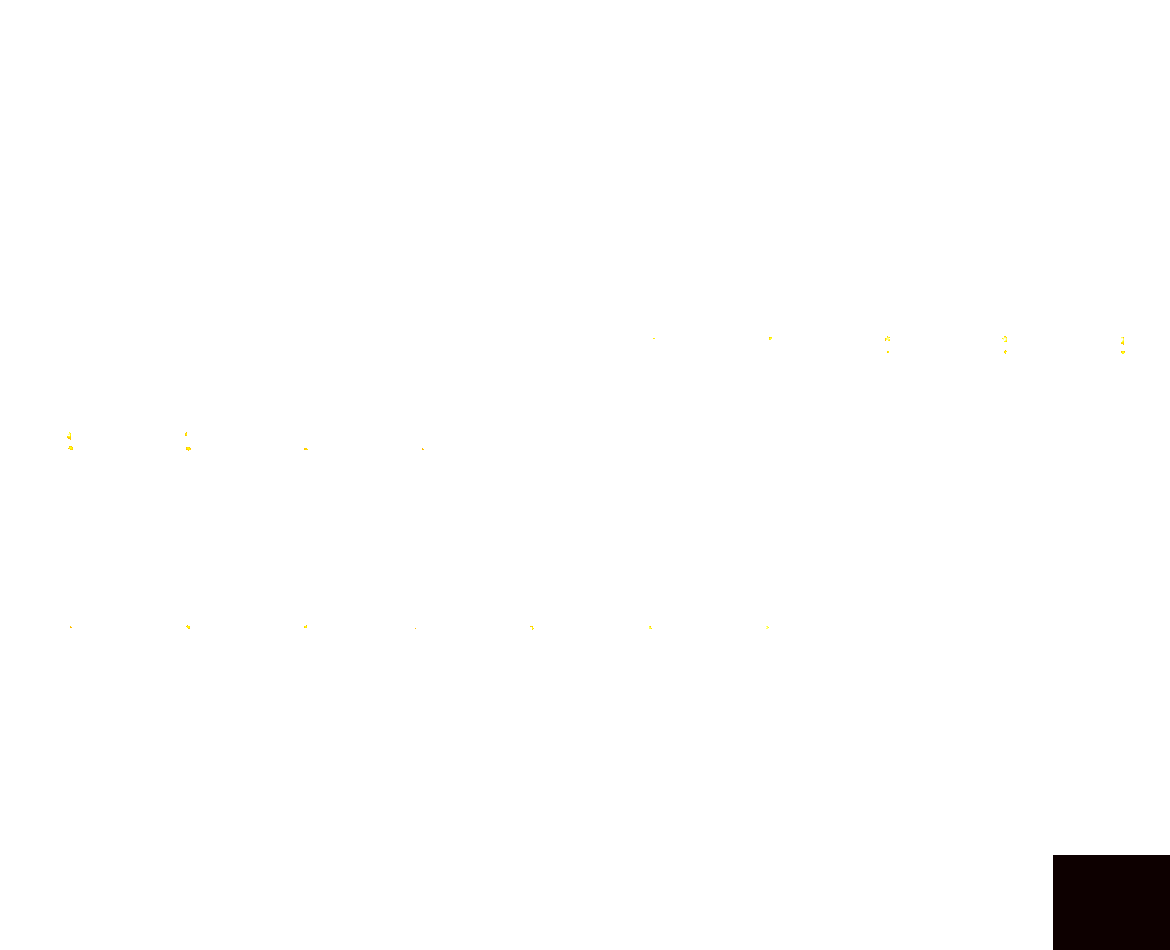

In [89]:
#| label: fig-glm-map-activeVSsham-reward-roi
print(f"Active vs. Sham | Imagery | {hc}({alpha}) | k>{ct} | Reward ROI")
nlp.view_img(corrected_map, colorbar=True)

In [90]:
#| label: tab-glm-clusters-activeVSsham-reward-roi
table_g,cluster_map_g = get_clusters_table(stat_maps_paired_masked['z_score'], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-20.0,4.0,8.0,3.091344,720,Putamen_L
1,2,34.0,-6.0,4.0,2.673116,168,Putamen_R
2,3,-20.0,6.0,-18.0,2.437039,488,Olfactory_L
3,4,24.0,8.0,2.0,2.332029,160,Putamen_R


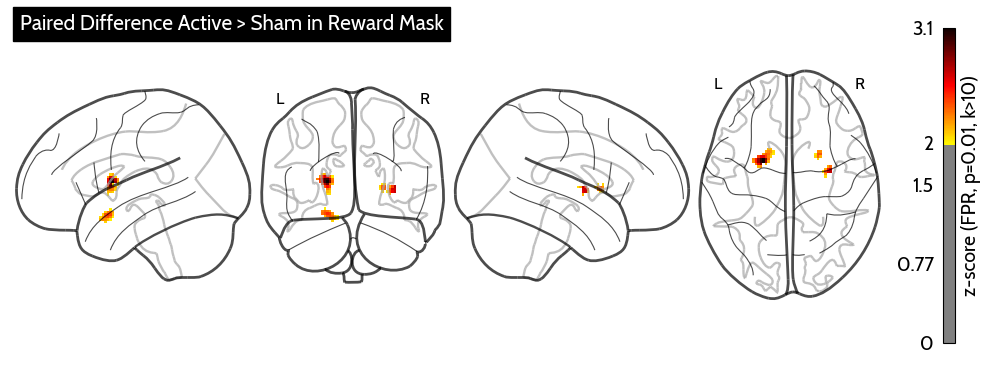

In [91]:
display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham in Reward Mask', 
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.01, k>10)')

In [92]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])
print(f"Average z-score in ROI: {B}")

C = stat_maps_paired_masked['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average z-score in ROI: 2.2673001581667864
Average p-value of significant voxels: 0.013645823832568038


# Target ROI from BrainVoyager

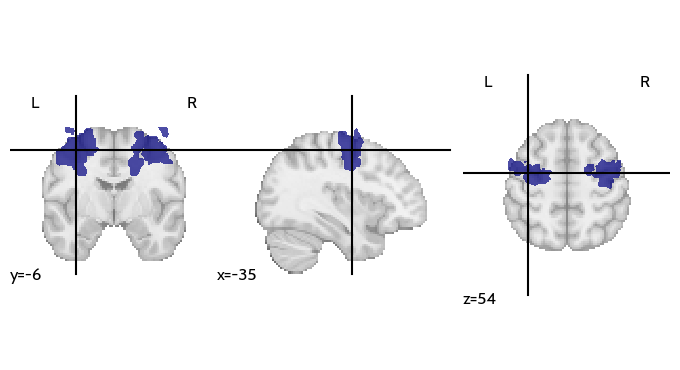

In [93]:
nii_path = '/Volumes/T7/BIDS-MUSICNF/derivatives/tbv-vois/MPM_targets_prob-map_region-labels.nii.gz'

roi_bin2 = math_img("img > 0", img=nii_path)
nlp.plot_roi(roi_bin2)

In [94]:
second_level_model_paired_masked2 = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin2).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked2 = second_level_model_paired_masked2.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



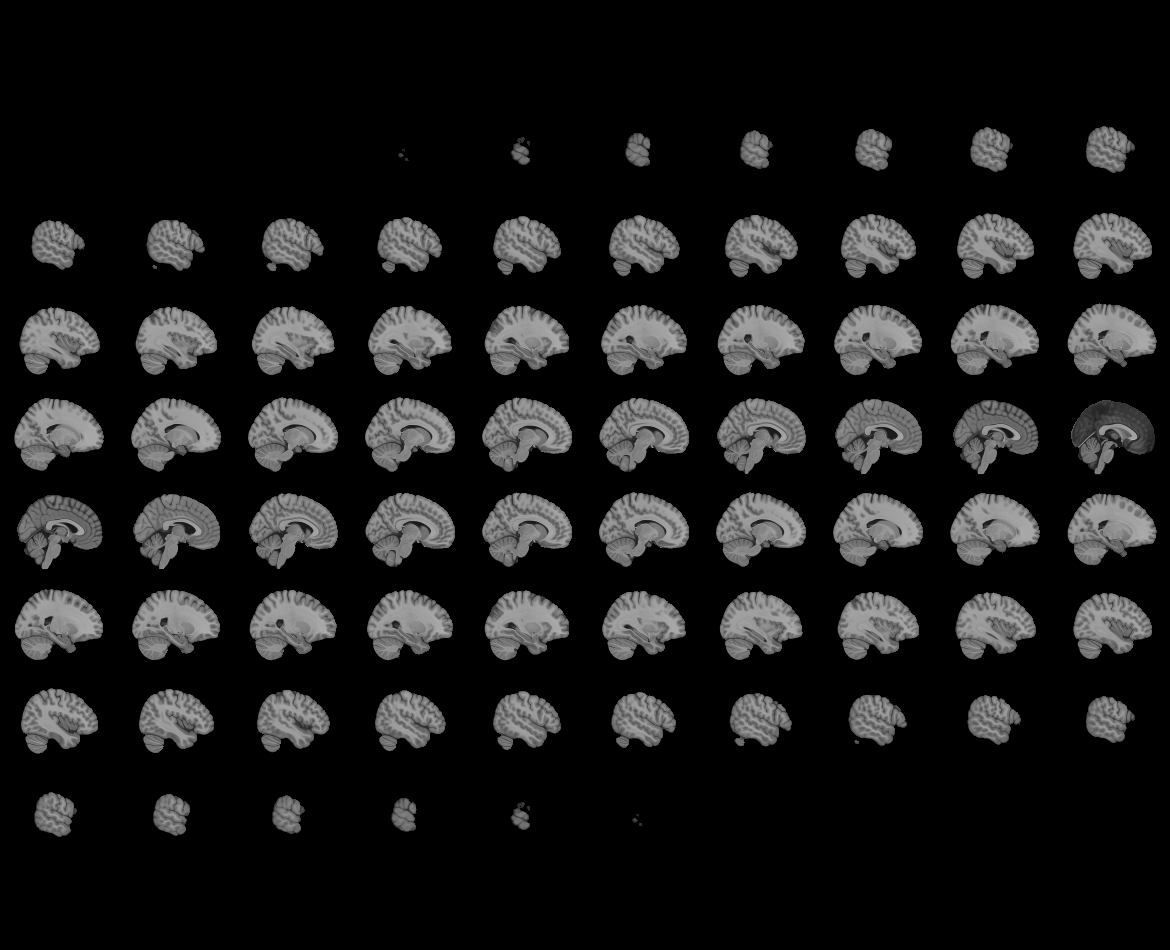
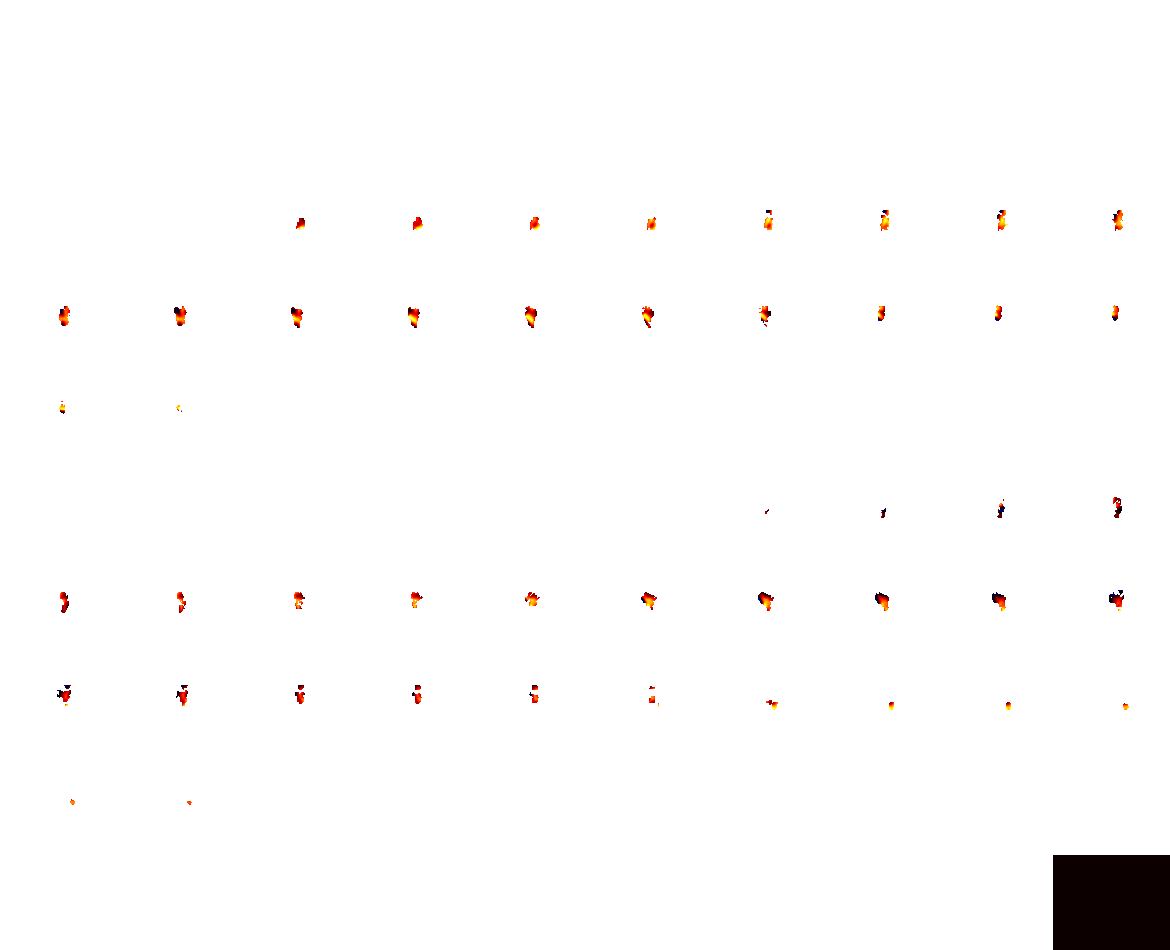

In [95]:
nlp.view_img(stat_maps_paired_masked2['z_score'], colorbar=True)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



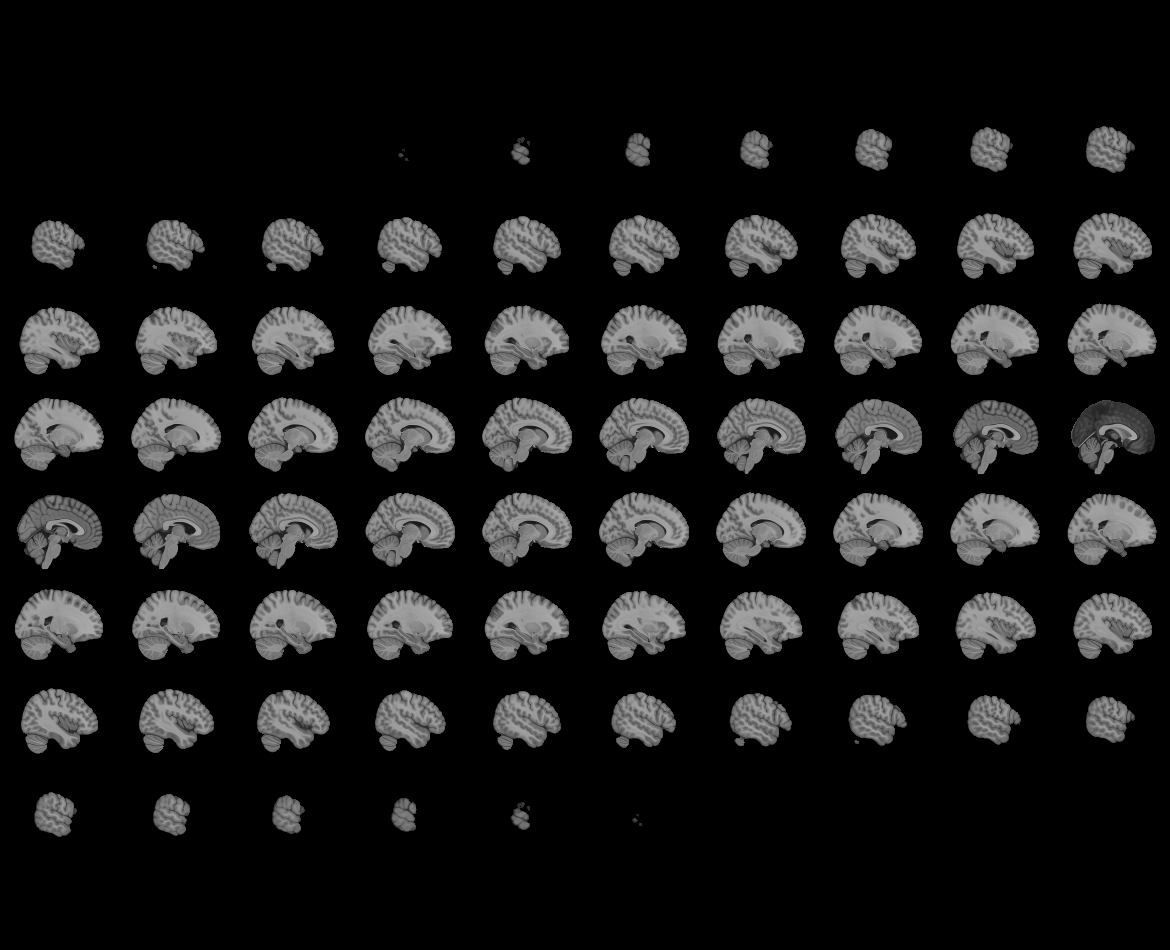
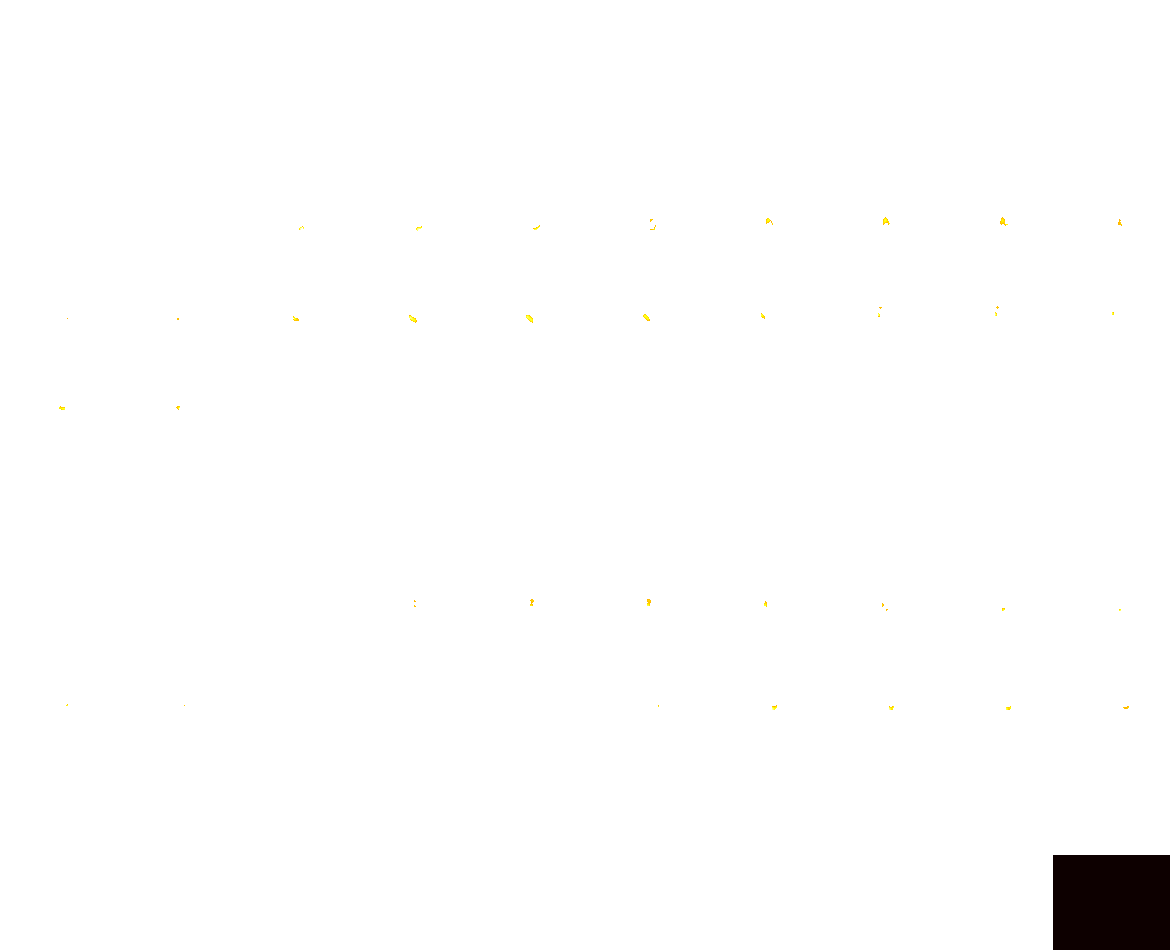

In [96]:
# threshold image
ct = 10
alpha = 0.05
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked2['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc)

nlp.view_img(corrected_map, threshold=thres, colorbar=True)

In [97]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])

print(f"Average z-score of significant voxels: {B}")

Average z-score of significant voxels: 2.2097175467009995


In [98]:
C = stat_maps_paired_masked2['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average p-value of significant voxels: 0.014971385181883892
